# Libraries

In [23]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import scipy as sp
import glob
from xml.etree import ElementTree as ET
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Model

In [24]:
classes = ['NoFX', 'Distortion', 'Tremolo']
n_mfcc =13

## MFCC computing function

In [25]:
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=512,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=20,
        fmin=133.33,
        fmax=6853.8,
    )
    
    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X)
    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]
    return mfcc

# Retrieving names of wave files in the dataset

In [26]:
fileNames_dict = {"NoFX": [], "Distortion": [], "Tremolo": []}
label_dict = {"NoFX": [], "Distortion": [], "Tremolo": []}

for index, c in enumerate(classes):
    waveFiles_path = "./Dataset/{}".format(c)
    fileNames_dict[c] = [f for f in os.listdir(waveFiles_path) if f.endswith('.wav')]
    label_dict[c] = np.ones(len(fileNames_dict[c]))*index   # Generates the label vector with values 0,1,2

fileNames_dict['Distortion'] = np.random.choice(fileNames_dict['Distortion'], size=624, replace=False) 
fileNames_dict['Tremolo'] = np.random.choice(fileNames_dict['Tremolo'], size=624, replace=False)
label_dict['Distortion'] = np.random.choice(label_dict['Distortion'],size=624)
label_dict['Tremolo'] = np.random.choice(label_dict['Tremolo'],size=624)

dict_train_features = {'NoFX': [], 'Distortion': [], 'Tremolo': []}
dict_test_features = {'NoFX': [], 'Distortion': [], 'Tremolo': []}

dict_train_labels = {'NoFX': [], 'Distortion': [], 'Tremolo': []}
dict_test_labels = {'NoFX': [], 'Distortion': [], 'Tremolo': []}

dict_train_features_rms = {'NoFX': [], 'Distortion': [], 'Tremolo': []}
dict_test_features_rms = {'NoFX': [], 'Distortion': [], 'Tremolo': []}
dict_train_labels_rms = {'NoFX': [], 'Distortion': [], 'Tremolo': []}
dict_test_labels_rms = {'NoFX': [], 'Distortion': [], 'Tremolo': []}

# Dataset partitioning

In [ ]:
for c in classes:
    dict_train_features[c], dict_test_features[c], dict_train_labels[c], dict_test_labels[c] = sklearn.model_selection.train_test_split(fileNames_dict[c], label_dict[c], test_size=0.3, train_size=0.7, shuffle=True)    
for c in classes:
    dict_train_features_rms[c] = dict_train_features[c]
    dict_test_features_rms[c] = dict_test_features[c]
    dict_train_labels_rms[c] = dict_train_labels[c]
    dict_test_labels_rms[c] = dict_test_labels[c]


# Computing MFCC

In [27]:
# Compute MFCC for train set
for c in classes:
    n_train_samples=len(dict_train_features[c])
    train_features = np.zeros((n_train_samples, n_mfcc))
    for index, f in enumerate(dict_train_features[c]):
        audio, fs = librosa.load(os.path.join("./Dataset/{}".format(c), f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        train_features[index, :] = np.mean(mfcc, axis=1)
    dict_train_features[c] = train_features

# Compute MFCC for test set
for c in classes:
    n_test_samples=len(dict_test_features[c])
    test_features = np.zeros((n_test_samples, n_mfcc))
    for index, f in enumerate(dict_test_features[c]):
        audio, fs = librosa.load(os.path.join("./Dataset/{}".format(c), f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        test_features[index, :] = np.mean(mfcc, axis=1)
    dict_test_features[c] = test_features

# Computing Root Mean Square

In [28]:
# Compute Root Mean Square for train set
for c in classes:
    n_train_samples=len(dict_train_features_rms[c])
    train_features = np.zeros(n_train_samples)
    for index, f in enumerate(dict_train_features_rms[c]):
        audio, fs = librosa.load(os.path.join("./Dataset/{}".format(c), f), sr=None)
        win_length = int(np.floor(0.01 * fs))
        hop_size = int(np.floor(0.0075 * fs)) 
        train_features[index] = np.mean(librosa.feature.rms(audio, frame_length=win_length, hop_length=hop_size))
    dict_train_features_rms[c] = train_features
    
# Compute Root Mean Square for test set
for c in classes:
    n_train_samples=len(dict_test_features_rms[c])
    train_features = np.zeros(n_train_samples)
    for index, f in enumerate(dict_test_features_rms[c]):
        audio, fs = librosa.load(os.path.join("./Dataset/{}".format(c), f), sr=None) 
        train_features[index] =  np.mean(librosa.feature.rms(audio, frame_length=win_length, hop_length=hop_size))
    dict_test_features_rms[c] = train_features

In [29]:
# Unificate all features in a single pair of dictionaries
d_train = {'NoFX':[[],[]], 'Distortion':[[],[]], 'Tremolo':[[],[]]}
d_test = {'NoFX':[[],[]], 'Distortion':[[],[]], 'Tremolo':[[],[]]}

for c in classes:
    d_train[c][0] = dict_train_features[c]
    d_train[c][1] = dict_train_features_rms[c]
    d_test[c][0] = dict_test_features[c]
    d_test[c][1] = dict_test_features_rms[c]

#  MFCC Visualizzation

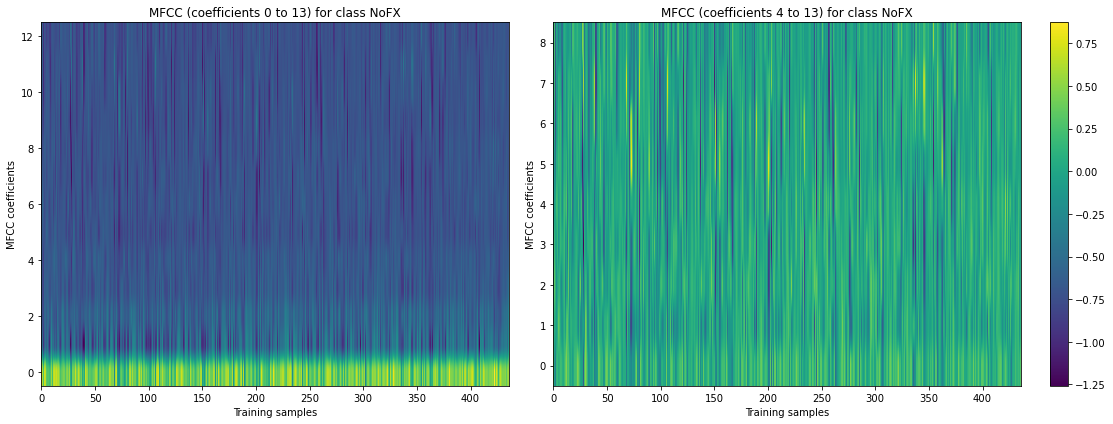

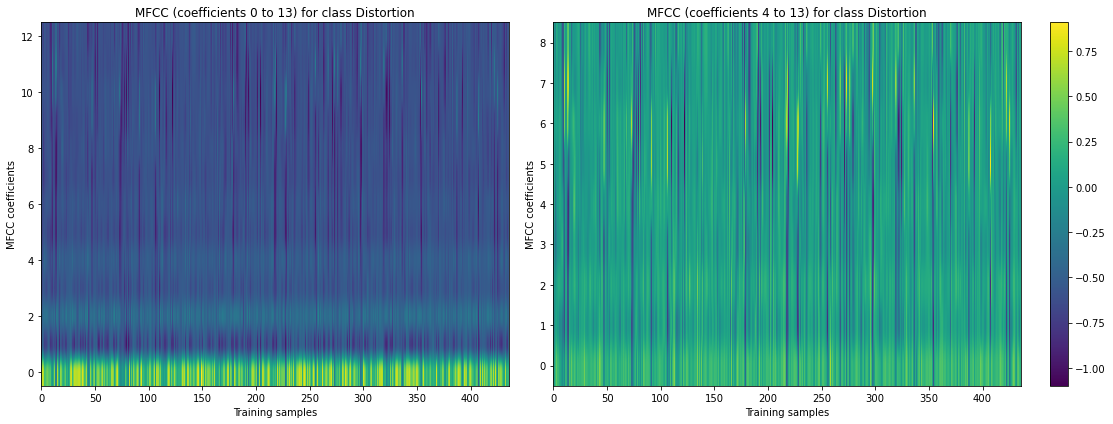

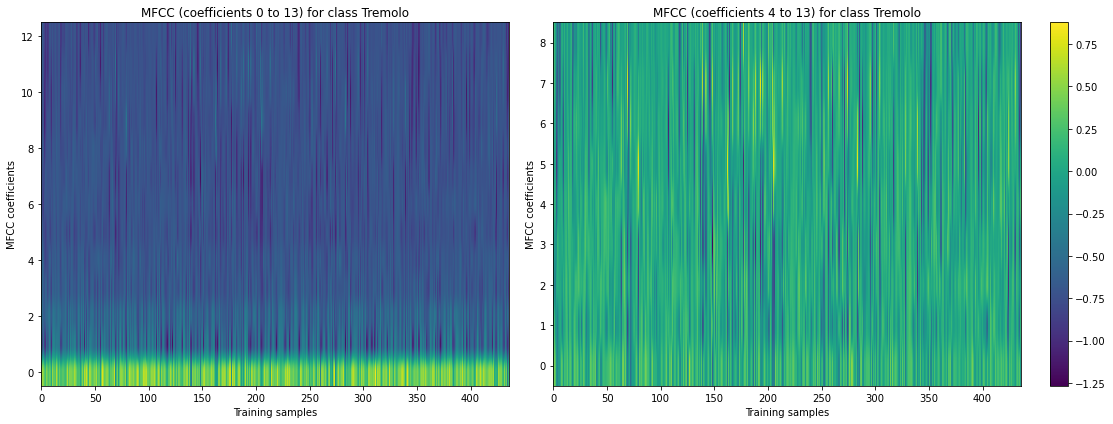

In [30]:
for c in classes:
    mfcc1 = d_train[c][0].transpose()
    # Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc1, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc1[4:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

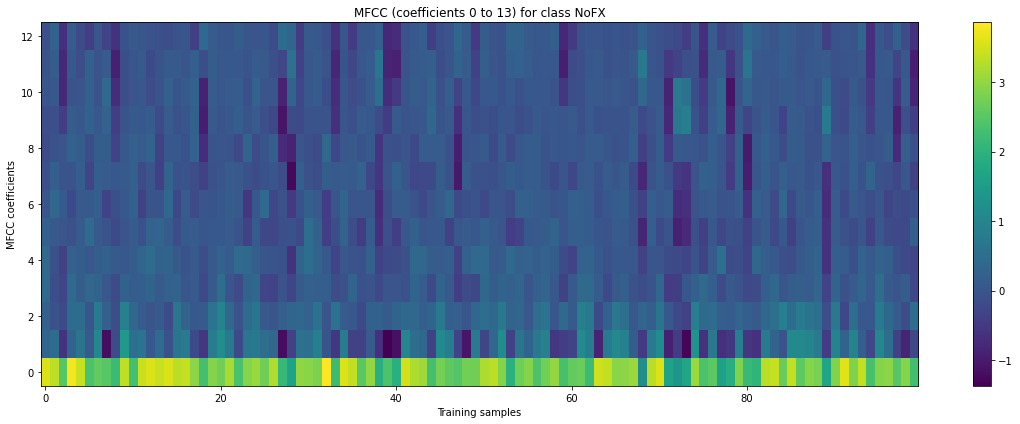

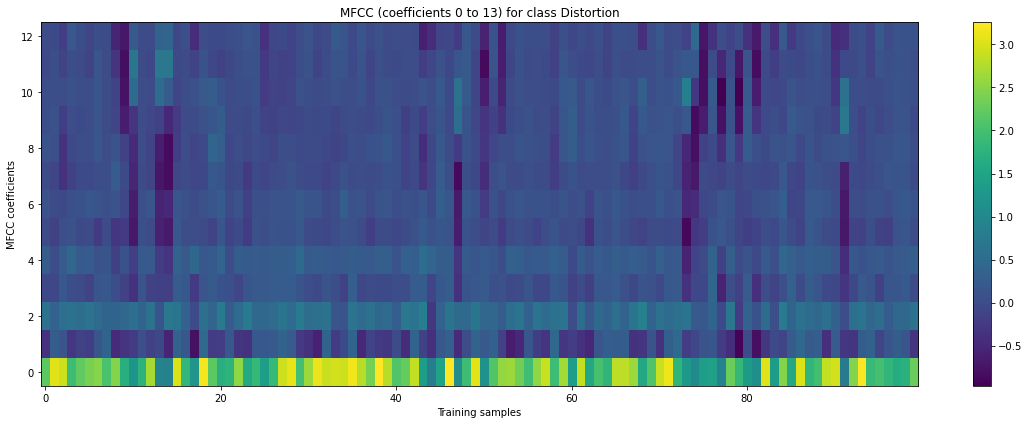

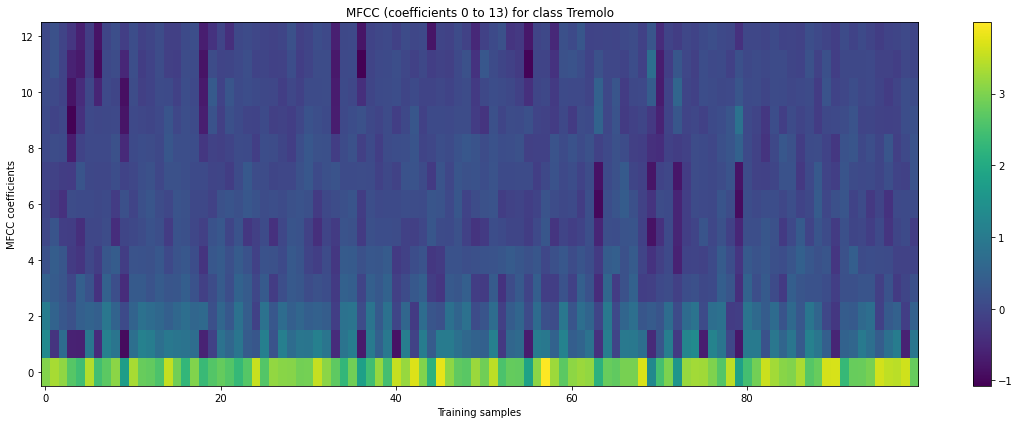

In [31]:
for c in classes:
    mfcc1 = d_train[c][0].transpose()
    # Partial Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.imshow(mfcc1[:, :100], origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

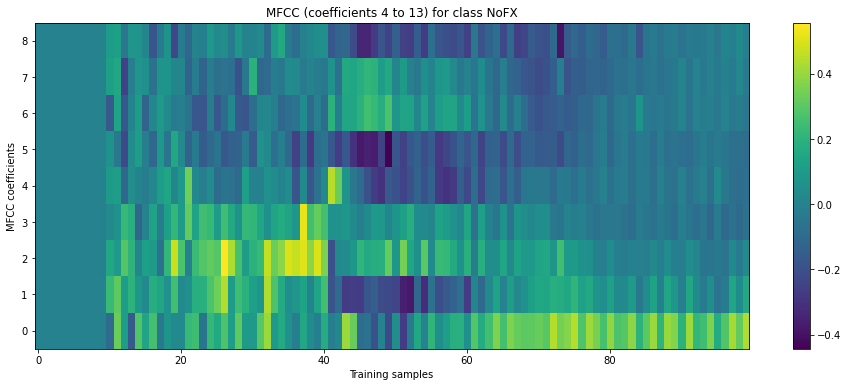

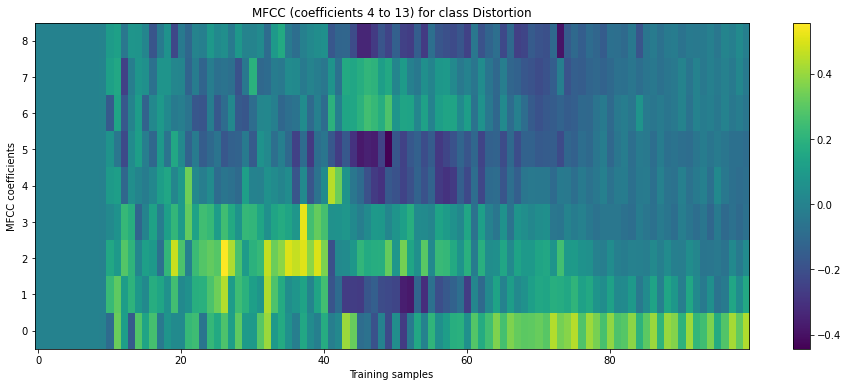

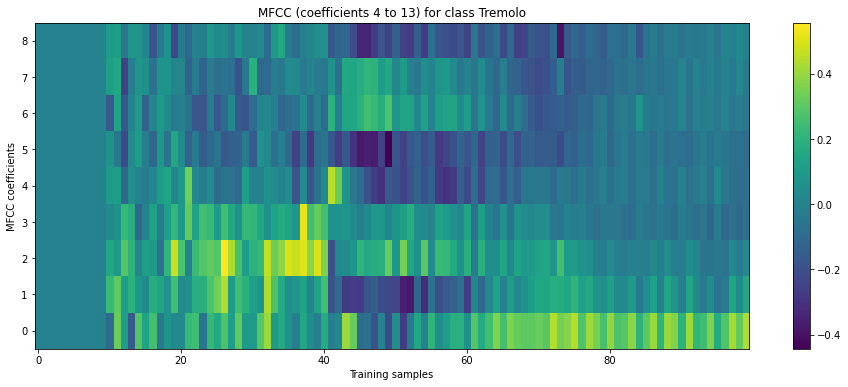

In [32]:
for c in classes:
    mfcc1 = d_train[c][0].transpose()
    # Partial Visualization
    fig = plt.figure(figsize=(16, 6))
    mfcc_upper = mfcc[4:, :100]
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()

# Model definition and training

In [33]:
feat_max = np.max(np.concatenate((d_train['NoFX'][0], d_train['Distortion'][0], d_train['Tremolo'][0]), axis=0), axis=0)
feat_min = np.min(np.concatenate((d_train['NoFX'][0], d_train['Distortion'][0], d_train['Tremolo'][0]), axis=0), axis=0)

feat_max_2 = np.max(np.concatenate((d_train['NoFX'][1], d_train['Distortion'][1], d_train['Tremolo'][1]), axis=0), axis=0)
feat_min_2 = np.min(np.concatenate((d_train['NoFX'][1], d_train['Distortion'][1], d_train['Tremolo'][1]), axis=0), axis=0)

X_train_0_normalized = (d_train['NoFX'][0] - feat_min) / (feat_max - feat_min)
X_train_1_normalized = (d_train['Distortion'][0] - feat_min) / (feat_max - feat_min)
X_train_2_normalized = (d_train['Tremolo'][0] - feat_min) / (feat_max - feat_min)

X_test_0_normalized = (d_test['NoFX'][0] - feat_min) / (feat_max - feat_min)
X_test_1_normalized = (d_test['Distortion'][0] - feat_min) / (feat_max - feat_min)
X_test_2_normalized = (d_test['Tremolo'][0] - feat_min) / (feat_max - feat_min)

X_test_mc_normalized = np.concatenate((X_test_0_normalized, X_test_1_normalized, X_test_2_normalized), axis=0)
y_test_mc = np.concatenate((dict_test_labels['NoFX'], dict_test_labels['Distortion'], dict_test_labels['Tremolo']), axis=0)

X_train_0_normalized_2 = (d_train['NoFX'][1] - feat_min_2) / (feat_max_2 - feat_min_2)
X_train_1_normalized_2 = (d_train['Distortion'][1] - feat_min_2) / (feat_max_2 - feat_min_2)
X_train_2_normalized_2 = (d_train['Tremolo'][1] - feat_min_2) / (feat_max_2 - feat_min_2)

X_train_0_normalized_2 = np.expand_dims(X_train_0_normalized_2, axis = 1)
X_train_1_normalized_2 = np.expand_dims(X_train_1_normalized_2, axis = 1)
X_train_2_normalized_2 = np.expand_dims(X_train_2_normalized_2, axis = 1)

X_test_0_normalized_2 = (d_test['NoFX'][1] - feat_min_2) / (feat_max_2 - feat_min_2)
X_test_1_normalized_2 = (d_test['Distortion'][1] - feat_min_2) / (feat_max_2 - feat_min_2)
X_test_2_normalized_2 = (d_test['Tremolo'][1] - feat_min_2) / (feat_max_2 - feat_min_2)

X_test_mc_normalized_2 = np.concatenate((X_test_0_normalized_2, X_test_1_normalized_2, X_test_2_normalized_2), axis=0)
X_test_mc_normalized_2 = np.expand_dims(X_test_mc_normalized_2, axis = 1)

In [34]:
SVM_parameters={
    'C':1,
    'kernel': 'poly',
}

clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True)

In [35]:
clf_01.fit(np.concatenate((X_train_0_normalized, X_train_1_normalized), axis=0), 
           np.concatenate((dict_train_labels['NoFX'], dict_train_labels['Distortion']), axis=0))

clf_02.fit(np.concatenate((X_train_0_normalized_2, X_train_2_normalized_2), axis=0), 
           np.concatenate((dict_train_labels['NoFX'], dict_train_labels['Tremolo']), axis=0))

clf_12.fit(np.concatenate((X_train_1_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((dict_train_labels['Distortion'], dict_train_labels['Tremolo']), axis=0))

SVC(C=1, kernel='poly', probability=True)

# Model's predictions over the test set

In [36]:
y_test_predicted_01 = clf_01.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_02 = clf_02.predict(X_test_mc_normalized_2).reshape(-1, 1)
y_test_predicted_12 = clf_12.predict(X_test_mc_normalized).reshape(-1, 1)

In [37]:
y_test_predicted_mc = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_12), axis=1)
y_test_predicted_mc = np.array(y_test_predicted_mc, dtype=np.int)

In [38]:
y_test_predicted_mv = np.zeros((y_test_predicted_mc.shape[0],))
for i, e in enumerate(y_test_predicted_mc):
    y_test_predicted_mv[i] = np.bincount(e).argmax() 

# Evaluation

In [39]:
def compute_cm_multiclass(gt, predicted):
    classes = np.unique(gt)
    CM = np.zeros((len(classes), len(classes)))
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    print(CM)

In [40]:
compute_cm_multiclass(y_test_mc, y_test_predicted_mv)

[[164.   4.  20.]
 [  4. 173.  11.]
 [ 36.   3. 149.]]


In [41]:
#Computing accuracy_score, precision_score, recall_score, f1_score

print('\nAccuracy: {:.5f}\n'.format(accuracy_score(y_test_mc, y_test_predicted_mv)))

# 'micro' parameter implies that the function Calculate metrics globally by counting the total true positives, 
#  false negatives and false positives.
print('Micro Precision: {:.5f}'.format(precision_score(y_test_mc, y_test_predicted_mv, average='micro')))
print('Micro Recall: {:.5f}'.format(recall_score(y_test_mc, y_test_predicted_mv, average='micro')))
print('Micro F1-score: {:.5f}\n'.format(f1_score(y_test_mc, y_test_predicted_mv, average='micro')))

# 'macro' parameter implies that the function calculates metrics for each label, and find their unweighted mean.
print('Macro Precision: {:.5f}'.format(precision_score(y_test_mc, y_test_predicted_mv, average='macro')))
print('Macro Recall: {:.5f}'.format(recall_score(y_test_mc, y_test_predicted_mv, average='macro')))
print('Macro F1-score: {:.5f}\n'.format(f1_score(y_test_mc, y_test_predicted_mv, average='macro')))

print('\nClassification Report\n')
print(classification_report(y_test_mc, y_test_predicted_mv, target_names=['NoFX', 'Distortion', 'Tremolo']))


Accuracy: 0.86170

Micro Precision: 0.86170
Micro Recall: 0.86170
Micro F1-score: 0.86170

Macro Precision: 0.86427
Macro Recall: 0.86170
Macro F1-score: 0.86224


Classification Report

              precision    recall  f1-score   support

        NoFX       0.80      0.87      0.84       188
  Distortion       0.96      0.92      0.94       188
     Tremolo       0.83      0.79      0.81       188

    accuracy                           0.86       564
   macro avg       0.86      0.86      0.86       564
weighted avg       0.86      0.86      0.86       564

